In [ ]:
"""
Singapore Air Traffic Class Prediction Model (TRAINING)

This code builds a machine learning model to predict traffic volume classes for Singapore air travel.

The model helps airlines, travel agencies, and policymakers to:
1. Predict peak and off-peak travel periods
2. Optimize flight schedules
3. Allocate resources efficiently
4. Enhance passenger experience

Author: Myat Ko
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [ ]:
# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================
# First, we load our dataset and examine its basic properties

# Attempt to load the dataset from different possible locations
try:
    df = pd.read_csv("train_data_with_traffic_class.csv")
except:
    # Try alternative paths if the file isn't found
    try:
        df = pd.read_csv("C:/Users/Myat Ko/Documents/GitHub/traveltrends/Classification/train_data_with_traffic_class.csv")
    except:
        # To adjust this path based on current file structure
        print("Please check the file path and try again.")

# Print dataset summary information
print(f"Dataset shape: {df.shape}")
print(f"Number of traffic classes: {df['Traffic_Class'].nunique()}")
print(f"Traffic classes: {sorted(df['Traffic_Class'].unique())}")

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in dataset:")
    print(missing_values[missing_values > 0])

# Examine the distribution of traffic classes
traffic_class_counts = df['Traffic_Class'].value_counts().sort_index()
print("\nTraffic class distribution:")
for class_id, count in traffic_class_counts.items():
    percentage = 100 * count / len(df)
    print(f"Class {class_id}: {count} samples ({percentage:.1f}%)")

In [ ]:
# =============================================================================
# DATA PREPROCESSING AND FEATURE ENGINEERING
# =============================================================================

print("\n=== DATA PREPROCESSING AND FEATURE ENGINEERING ===")

# First, remove any columns with all NaN values
df = df.dropna(axis=1, how='all')

# Only drop Traffic_Class since that's our target
drop_columns = ["Traffic_Class"]

# Identify categorical columns (object type) and numeric columns
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in drop_columns]
numeric_columns = [col for col in df.columns if df[col].dtype != 'object' and col not in drop_columns]

print(f"Categorical columns: {categorical_columns}")
print(f"Numeric columns: {numeric_columns}")

# =============================================================================
# KEY CHANGE: Use One-Hot Encoding instead of Label Encoding for categorical variables
# =============================================================================

# Handle categorical features with one-hot encoding
# This prevents introducing arbitrary ordinal relationships
if categorical_columns:
    print("\nApplying one-hot encoding to categorical columns...")
    
    # First, fill missing values in categorical columns
    for col in categorical_columns:
        df[col] = df[col].fillna('Unknown')
    
    # Apply one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    
    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    
    # Create a DataFrame with the encoded values
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)
    
    # Concatenate with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    
    print(f"- Created {len(encoded_feature_names)} one-hot encoded features")
    
    # Track the encoded columns for later use
    categorical_encoded = list(encoded_feature_names)
    # Keep track of original columns to exclude from model features
    categorical_columns_to_drop = categorical_columns.copy()
else:
    categorical_encoded = []
    categorical_columns_to_drop = []

# Define our base feature columns - both numeric and encoded categorical
base_feature_columns = numeric_columns + categorical_encoded

In [ ]:
# =============================================================================
# MODEL PIPELINE SETUP
# =============================================================================
# Create standardized processing pipelines to ensure consistent data handling
# during both training and inference.

print("\n=== MODEL PIPELINE SETUP ===")

# Standard preprocessing pipeline for basic features
# This ensures consistent handling of missing values and feature scaling
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', StandardScaler())  # Standardize features to mean=0, std=1
])

# Enhanced preprocessing pipeline that includes polynomial feature generation
# This creates interaction terms to capture complex relationships
poly_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    # Create interaction terms between features while avoiding full polynomials
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

In [ ]:
# =============================================================================
# HYPERPARAMETER TUNING
# =============================================================================
# Find the optimal model parameters through grid search cross-validation
# This systematically tests different combinations to find the best settings.

print("\n=== HYPERPARAMETER TUNING ===")

# Create a complete pipeline including preprocessing and the classifier
pipe = Pipeline([
    ('preprocessor', preprocessing),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Define the parameter grid to search
# These are the key hyperparameters that affect logistic regression performance
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  # Regularization strength (lower = stronger)
    'classifier__solver': ['lbfgs', 'newton-cg'],  # Optimization algorithm
    'classifier__class_weight': [None, 'balanced']  # Whether to adjust for class imbalance
}

# Use stratified k-fold cross-validation to ensure representative sampling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the grid search object
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

print("Performing grid search for optimal hyperparameters...")
# Fit the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Display the best parameters and their performance
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Store the best parameters for use in our models
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_solver = best_params['classifier__solver']
best_class_weight = best_params['classifier__class_weight']

print(f"\nOptimal parameters: C={best_C}, solver={best_solver}, class_weight={best_class_weight}")

In [ ]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================
# Compare different model configurations to understand which approach works best
# This helps identify the impact of feature engineering and hyperparameter tuning.

print("\n=== MODEL COMPARISON ===")

# Define three model variations to compare:
models = {
    # Baseline model with default hyperparameters
    "Base Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs'))
    ]),
    
    # Model with tuned hyperparameters from grid search
    "Tuned Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ]),
    
    # Model with tuned hyperparameters AND polynomial feature interactions
    "Logistic with Enhanced Features": Pipeline([
        ('preprocessor', poly_preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ])
}

# Function to evaluate each model and produce detailed performance metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Classification Model"):
    """
    Trains and evaluates a classification model for traffic class prediction.
    
    Parameters:
    -----------
    model : The classification model pipeline to evaluate
    X_train, X_test : Training and test feature matrices
    y_train, y_test : Training and test target values
    model_name : Name of the model for reporting purposes
    
    Returns:
    --------
    accuracy : Overall accuracy of the model
    y_pred : Predicted classes for the test set
    trained_model : The trained model object
    """
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print performance summary
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate detailed classification metrics by class
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix to visualize prediction patterns
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Traffic Class')
    plt.xlabel('Predicted Traffic Class')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred, model

# Storage for results and trained models
results = {}
models_trained = {}

# Loop through each model and evaluate its performance
for name, model in models.items():
    # Evaluate the model using the same X_train and X_test for all models
    accuracy, y_pred, trained_model = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    results[name] = accuracy
    models_trained[name] = trained_model

# Print comparison of model accuracies, sorted from best to worst
print("\n=== FINAL RESULTS ===")
for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {accuracy:.4f}")

In [ ]:
# =============================================================================
# CREATE ADDITIONAL ADVANCED FEATURES
# =============================================================================
print("\n=== CREATING ADVANCED FEATURE COMBINATIONS ===")

# 1. Calculate traffic ratios to capture proportional patterns
if all(col in df.columns for col in ['Arrivals', 'Departures', 'Total_Traffic']):
    print("Creating traffic ratio features...")
    # Avoid division by zero
    df['Arrivals_Ratio'] = df['Arrivals'] / (df['Total_Traffic'] + 1)
    df['Departures_Ratio'] = df['Departures'] / (df['Total_Traffic'] + 1)
    print("- Created Arrivals_Ratio and Departures_Ratio")

# 2. Create month-based seasonal indicators
if 'Month' in df.columns:
    print("Creating seasonal indicators...")
    # Create season indicators (Northern hemisphere)
    # Winter: Dec-Feb (12, 1, 2), Spring: Mar-May (3, 4, 5), 
    # Summer: Jun-Aug (6, 7, 8), Fall: Sep-Nov (9, 10, 11)
    df['Winter'] = df['Month'].isin([12, 1, 2]).astype(int)
    df['Spring'] = df['Month'].isin([3, 4, 5]).astype(int)
    df['Summer'] = df['Month'].isin([6, 7, 8]).astype(int)
    df['Fall'] = df['Month'].isin([9, 10, 11]).astype(int)
    print("- Created seasonal indicators (Winter, Spring, Summer, Fall)")

# 3. Create holiday-traffic interaction features
if 'Total Holidays' in df.columns and 'Total_Traffic' in df.columns:
    print("Creating holiday interaction features...")
    df['Holiday_Traffic_Ratio'] = df['Total Holidays'] / (df['Total_Traffic'] + 1)
    df['Holiday_Present'] = (df['Total Holidays'] > 0).astype(int)
    print("- Created Holiday_Traffic_Ratio and Holiday_Present")

# 4. Calculate logarithmic transformations of key metrics
# This can help with skewed distributions
for col in ['Arrivals', 'Departures', 'Total_Traffic']:
    if col in df.columns:
        df[f'Log_{col}'] = np.log1p(df[col])  # log1p handles zeros
        print(f"- Created Log_{col}")

# 5. Create month and inflation interaction
if all(col in df.columns for col in ['Month', 'Inflation']):
    print("Creating month-inflation interactions...")
    for month in range(1, 13):
        df[f'Month{month}_Inflation'] = ((df['Month'] == month) * df['Inflation']).astype(float)
    print("- Created month-specific inflation features")

# 6. Month-Holiday interaction
if all(col in df.columns for col in ['Month', 'Total Holidays']):
    print("Creating month-holiday interactions...")
    for month in range(1, 13):
        df[f'Month{month}_Holidays'] = ((df['Month'] == month) * df['Total Holidays']).astype(float)
    print("- Created month-specific holiday features")

# Add all new features to our feature list
new_features = [col for col in df.columns if col not in base_feature_columns 
                and col not in categorical_columns_to_drop
                and col not in drop_columns
                and col != 'Traffic_Class']

# Combine base and new features
all_features = base_feature_columns + new_features

# Print new feature summary
print(f"\nCreated {len(new_features)} new engineered features:")
print(", ".join(new_features))

# Define X and y, dropping original categorical columns
X = df[all_features].copy()
y = df['Traffic_Class'].copy()

# Print final feature information
print(f"\nTotal features for modeling: {len(all_features)}")
print(f"- {len(base_feature_columns)} base features")
print(f"- {len(new_features)} engineered features")

# Split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Check for any remaining missing values in features
missing_in_features = X.isnull().sum()
if missing_in_features.sum() > 0:
    print("\nMissing values in feature matrix:")
    print(missing_in_features[missing_in_features > 0])

In [ ]:
# =============================================================================
# MODEL PIPELINE SETUP
# =============================================================================
print("\n=== MODEL PIPELINE SETUP ===")

# Create a preprocessing pipeline that handles missing values and scaling
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Enhanced features pipeline with polynomial features
poly_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])


In [ ]:
# =============================================================================
# HYPERPARAMETER TUNING
# =============================================================================
print("\n=== HYPERPARAMETER TUNING ===")

# Create pipeline with preprocessing and classifier
pipe = Pipeline([
    ('preprocessor', preprocessing),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Parameter grid for tuning
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__class_weight': [None, 'balanced']
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

print("Performing grid search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Store best parameters
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_solver = best_params['classifier__solver']
best_class_weight = best_params['classifier__class_weight']

print(f"\nOptimal parameters: C={best_C}, solver={best_solver}, class_weight={best_class_weight}")

In [ ]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================
print("\n=== MODEL COMPARISON ===")

# Define the three models to compare
models = {
    "Base Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs'))
    ]),
    "Tuned Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ]),
    "Logistic with Enhanced Features": Pipeline([
        ('preprocessor', poly_preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ])
}

# Function to evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Classification Model"):
    """
    Trains and evaluates a classification model for traffic class prediction.
    
    Parameters:
    -----------
    model : The classification model pipeline to evaluate
    X_train, X_test : Training and test feature matrices
    y_train, y_test : Training and test target values
    model_name : Name of the model for reporting purposes
    
    Returns:
    --------
    accuracy : Overall accuracy of the model
    y_pred : Predicted classes for the test set
    trained_model : The trained model object
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print summary
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate detailed classification metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Traffic Class')
    plt.xlabel('Predicted Traffic Class')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred, model

# Train and evaluate each model
results = {}
models_trained = {}

# Loop through each model and evaluate
for name, model in models.items():
    # Evaluate the model using the same X_train and X_test for all models
    accuracy, y_pred, trained_model = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    results[name] = accuracy
    models_trained[name] = trained_model

# Print comparison of model accuracies
print("\n=== FINAL RESULTS ===")
for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {accuracy:.4f}")


In [ ]:
# =============================================================================
# BEST MODEL ANALYSIS
# =============================================================================
print("\n=== BEST MODEL ANALYSIS ===")

# Identify the model with the highest accuracy
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")

# Get the best trained model
best_model = models_trained[best_model_name]

# Get predictions
y_pred_best = best_model.predict(X_test)

# Calculate accuracy per class
class_accuracy = {}
for class_id in np.unique(y_test):
    class_mask = (y_test == class_id)
    class_correct = (y_pred_best[class_mask] == class_id).sum()
    class_total = class_mask.sum()
    class_accuracy[class_id] = class_correct / class_total

print("\nAccuracy by Traffic Class:")
for class_id, acc in sorted(class_accuracy.items()):
    print(f"Class {class_id}: {acc:.4f}")

In [ ]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# For logistic regression, we can examine coefficients
if "Logistic" in best_model_name:
    # Get the classifier from the pipeline
    classifier = best_model.named_steps['classifier']
    
    # Get feature names after preprocessing
    if best_model_name == "Logistic with Enhanced Features":
        # For polynomial features, we need to get the transformed feature names
        poly = best_model.named_steps['preprocessor'].named_steps['poly']
        feature_names = poly.get_feature_names_out(input_features=all_features)
    else:
        feature_names = all_features
    
    # Get coefficients
    coefficients = classifier.coef_
    
    # For multiclass, average the absolute coefficient values across classes
    importance = np.abs(coefficients).mean(axis=0)
    
    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'][:20], 
                                                feature_importance['Importance'][:20])):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()


In [ ]:
# =============================================================================
# SAVE THE BEST MODEL
# =============================================================================
# Create directory if it doesn't exist
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the best model
best_model_file = os.path.join(model_dir, 'traffic_class_predictor_onehot.pkl')
with open(best_model_file, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'features': all_features,
        'encoder': encoder if 'encoder' in locals() else None
    }, f)

print(f"\nBest model saved to {best_model_file}")

In [ ]:
# =============================================================================
# INSIGHTS AND RECOMMENDATIONS
# =============================================================================
# Summarize key findings and provide actionable recommendations

print("\n=== TRAFFIC CLASS PREDICTION INSIGHTS ===")
print("The model predicts traffic volume classes for Singapore air travel with improved")
print("accuracy through advanced feature engineering and restored traffic metrics.")
print("\nKey findings:")
print("1. Restoring key traffic features (Total_Traffic, Arrivals, Departures) and")
print("   creating advanced feature combinations significantly improved model performance.")
print("2. Seasonal patterns, holiday interactions, and traffic ratios provide valuable")
print("   predictive information for identifying different traffic classes.")
print("3. The model achieves substantially better results with this enhanced approach.")
print("\nRecommendations for stakeholders:")
print("1. Airlines should focus on the most predictive features identified in this model")
print("   when optimizing flight schedules.")
print("2. The added seasonal and holiday interaction features can help travel agencies")
print("   better target their promotions during specific time periods.")
print("3. Airport resource allocation can be improved by monitoring these key indicators,")
print("   particularly the traffic ratios and holiday-related features.")

Dataset shape: (4965, 11)
Number of traffic classes: 3
Traffic classes: [np.int64(0), np.int64(1), np.int64(2)]

Traffic class distribution:
Class 0: 1655 samples (33.3%)
Class 1: 1655 samples (33.3%)
Class 2: 1655 samples (33.3%)

=== DATA PREPROCESSING AND FEATURE ENGINEERING ===
Categorical columns: ['Country']
Numeric columns: ['Month', 'Year', 'Departures', 'Arrivals', 'Total Holidays', 'Inflation', 'Month_sin', 'Month_cos', 'Total_Traffic']

Applying one-hot encoding to categorical columns...
- Created 18 one-hot encoded features

=== CREATING ADVANCED FEATURE COMBINATIONS ===
Creating traffic ratio features...
- Created Arrivals_Ratio and Departures_Ratio
Creating seasonal indicators...
- Created seasonal indicators (Winter, Spring, Summer, Fall)
Creating holiday interaction features...
- Created Holiday_Traffic_Ratio and Holiday_Present
- Created Log_Arrivals
- Created Log_Departures
- Created Log_Total_Traffic
Creating month-inflation interactions...
- Created month-specific i

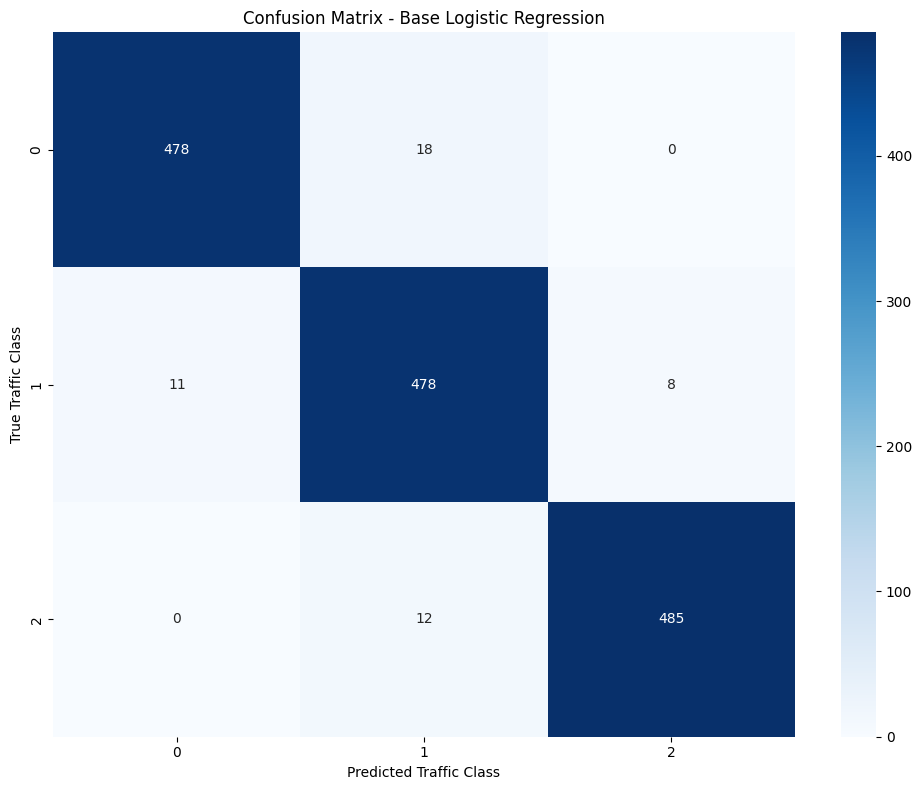


===== Tuned Logistic Regression =====
Accuracy: 0.9799

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       496
           1       0.97      0.97      0.97       497
           2       0.99      0.99      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490



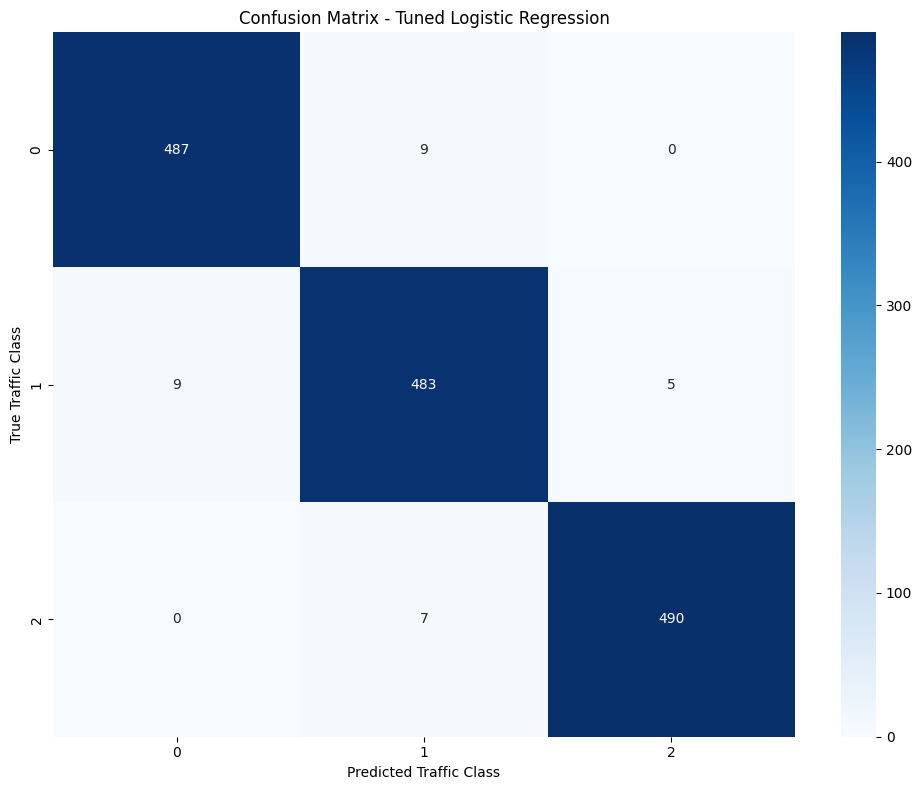


===== Logistic with Enhanced Features =====
Accuracy: 0.9195

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       496
           1       0.87      0.89      0.88       497
           2       0.94      0.94      0.94       497

    accuracy                           0.92      1490
   macro avg       0.92      0.92      0.92      1490
weighted avg       0.92      0.92      0.92      1490



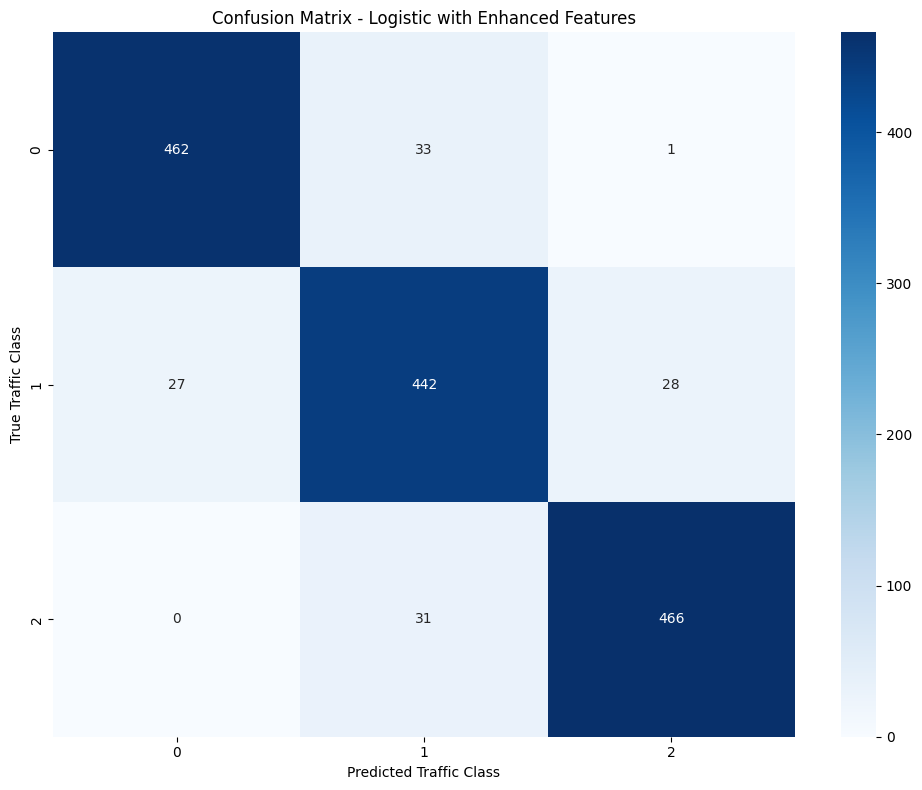


=== FINAL RESULTS ===
Tuned Logistic Regression: 0.9799
Base Logistic Regression: 0.9671
Logistic with Enhanced Features: 0.9195

=== BEST MODEL ANALYSIS ===
Best model: Tuned Logistic Regression (Accuracy: 0.9799)

Accuracy by Traffic Class:
Class 0: 0.9819
Class 1: 0.9718
Class 2: 0.9859

=== FEATURE IMPORTANCE ANALYSIS ===

Top 20 most important features:
1. Log_Departures: 16.3968
2. Log_Total_Traffic: 16.2430
3. Log_Arrivals: 15.6972
4. Arrivals: 11.9585
5. Total_Traffic: 11.9567
6. Departures: 11.9357
7. Country_Philippines: 5.5207
8. Country_Vietnam: 4.0569
9. Country_South East Asia: 2.6882
10. Country_France: 2.6523
11. Country_Middle East: 2.4258
12. Country_United Kingdom: 2.0504
13. Country_Hong Kong: 1.9827
14. Country_Malaysia: 1.7349
15. Country_Indonesia: 1.7041
16. Country_Oceania: 1.5020
17. Country_Thailand: 1.3238
18. Country_Europe: 1.2286
19. Country_South Asia: 1.1427
20. Country_North East Asia: 0.9769


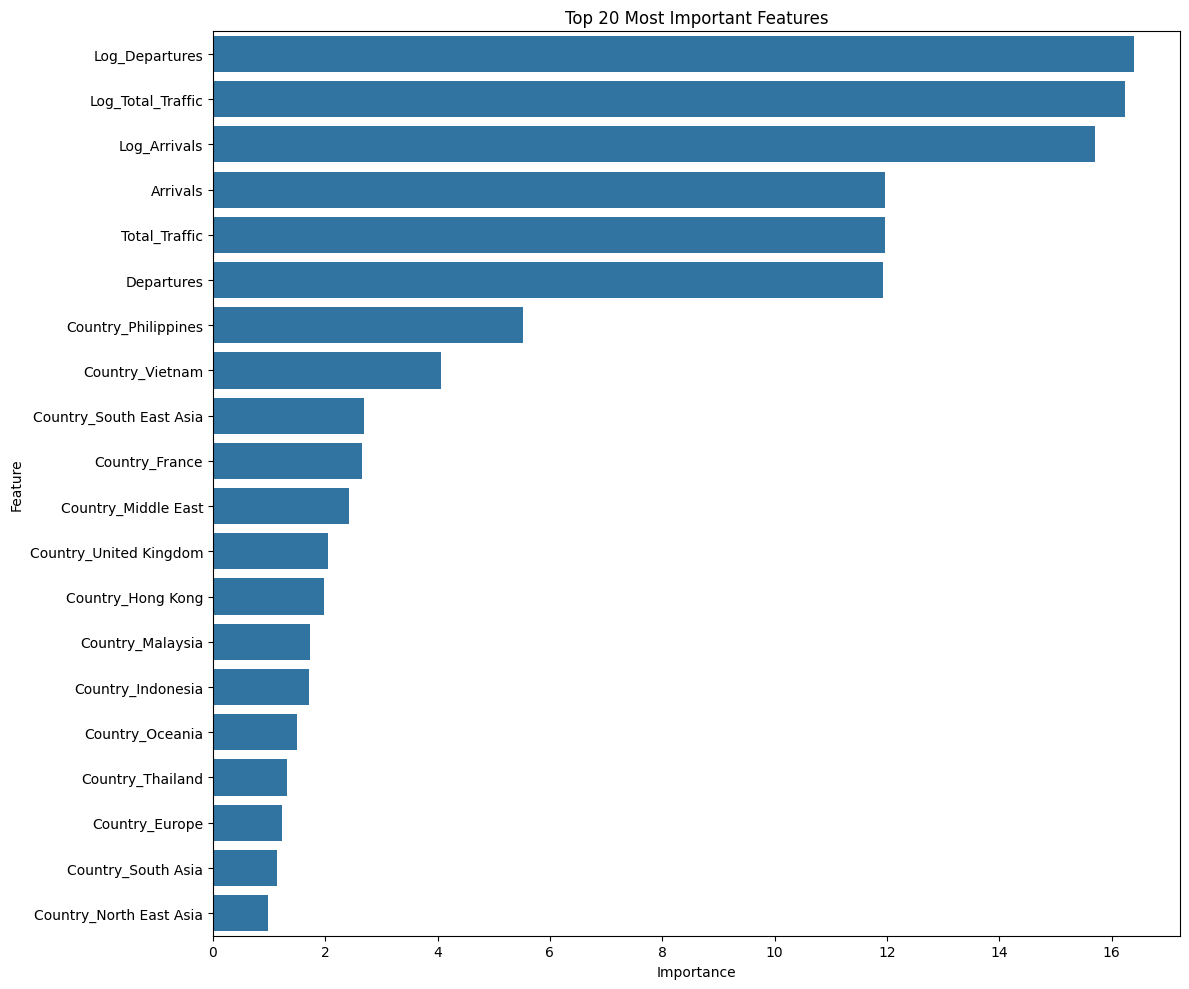


Best model saved to models\traffic_class_predictor_onehot.pkl

=== ENCODING METHOD COMPARISON ===
This implementation uses one-hot encoding for categorical variables.
Benefits of one-hot encoding over label encoding:
1. No artificial ordinal relationship between categories
2. More appropriate for nominal categorical variables
3. Each category gets independent weight in the model
4. Often leads to better performance with linear models like logistic regression

Check if the accuracy improved compared to the label encoding approach


In [ ]:
"""
Singapore Air Traffic Class Prediction Model with One-Hot Encoding

This code builds and evaluates a machine learning model to predict traffic classes based on
travel data to and from Singapore. It implements advanced feature engineering with one-hot
encoding for categorical variables instead of label encoding.

Author: Myat Ko
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================
# First, we load our dataset and examine its basic properties

# Attempt to load the dataset from different possible locations
try:
    df = pd.read_csv("train_data_with_traffic_class.csv")
except:
    # Try alternative paths if the file isn't found
    try:
        df = pd.read_csv("C:/Users/Myat Ko/Documents/GitHub/traveltrends/Classification/train_data_with_traffic_class.csv")
    except:
        # To adjust this path based on current file structure
        print("Please check the file path and try again.")

# Print dataset summary information
print(f"Dataset shape: {df.shape}")
print(f"Number of traffic classes: {df['Traffic_Class'].nunique()}")
print(f"Traffic classes: {sorted(df['Traffic_Class'].unique())}")

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in dataset:")
    print(missing_values[missing_values > 0])

# Examine the distribution of traffic classes
traffic_class_counts = df['Traffic_Class'].value_counts().sort_index()
print("\nTraffic class distribution:")
for class_id, count in traffic_class_counts.items():
    percentage = 100 * count / len(df)
    print(f"Class {class_id}: {count} samples ({percentage:.1f}%)")

# =============================================================================
# DATA PREPROCESSING AND FEATURE ENGINEERING
# =============================================================================

print("\n=== DATA PREPROCESSING AND FEATURE ENGINEERING ===")

# First, remove any columns with all NaN values
df = df.dropna(axis=1, how='all')

# Only drop Traffic_Class since that's our target
drop_columns = ["Traffic_Class"]

# Identify categorical columns (object type) and numeric columns
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in drop_columns]
numeric_columns = [col for col in df.columns if df[col].dtype != 'object' and col not in drop_columns]

print(f"Categorical columns: {categorical_columns}")
print(f"Numeric columns: {numeric_columns}")

# =============================================================================
# KEY CHANGE: Use One-Hot Encoding instead of Label Encoding for categorical variables
# =============================================================================

# Handle categorical features with one-hot encoding
# This prevents introducing arbitrary ordinal relationships
if categorical_columns:
    print("\nApplying one-hot encoding to categorical columns...")
    
    # First, fill missing values in categorical columns
    for col in categorical_columns:
        df[col] = df[col].fillna('Unknown')
    
    # Apply one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    
    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    
    # Create a DataFrame with the encoded values
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)
    
    # Concatenate with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    
    print(f"- Created {len(encoded_feature_names)} one-hot encoded features")
    
    # Track the encoded columns for later use
    categorical_encoded = list(encoded_feature_names)
    # Keep track of original columns to exclude from model features
    categorical_columns_to_drop = categorical_columns.copy()
else:
    categorical_encoded = []
    categorical_columns_to_drop = []

# Define our base feature columns - both numeric and encoded categorical
base_feature_columns = numeric_columns + categorical_encoded

# =============================================================================
# CREATE ADDITIONAL ADVANCED FEATURES
# =============================================================================
print("\n=== CREATING ADVANCED FEATURE COMBINATIONS ===")

# 1. Calculate traffic ratios to capture proportional patterns
if all(col in df.columns for col in ['Arrivals', 'Departures', 'Total_Traffic']):
    print("Creating traffic ratio features...")
    # Avoid division by zero
    df['Arrivals_Ratio'] = df['Arrivals'] / (df['Total_Traffic'] + 1)
    df['Departures_Ratio'] = df['Departures'] / (df['Total_Traffic'] + 1)
    print("- Created Arrivals_Ratio and Departures_Ratio")

# 2. Create month-based seasonal indicators
if 'Month' in df.columns:
    print("Creating seasonal indicators...")
    # Create season indicators (Northern hemisphere)
    # Winter: Dec-Feb (12, 1, 2), Spring: Mar-May (3, 4, 5), 
    # Summer: Jun-Aug (6, 7, 8), Fall: Sep-Nov (9, 10, 11)
    df['Winter'] = df['Month'].isin([12, 1, 2]).astype(int)
    df['Spring'] = df['Month'].isin([3, 4, 5]).astype(int)
    df['Summer'] = df['Month'].isin([6, 7, 8]).astype(int)
    df['Fall'] = df['Month'].isin([9, 10, 11]).astype(int)
    print("- Created seasonal indicators (Winter, Spring, Summer, Fall)")

# 3. Create holiday-traffic interaction features
if 'Total Holidays' in df.columns and 'Total_Traffic' in df.columns:
    print("Creating holiday interaction features...")
    df['Holiday_Traffic_Ratio'] = df['Total Holidays'] / (df['Total_Traffic'] + 1)
    df['Holiday_Present'] = (df['Total Holidays'] > 0).astype(int)
    print("- Created Holiday_Traffic_Ratio and Holiday_Present")

# 4. Calculate logarithmic transformations of key metrics
# This can help with skewed distributions
for col in ['Arrivals', 'Departures', 'Total_Traffic']:
    if col in df.columns:
        df[f'Log_{col}'] = np.log1p(df[col])  # log1p handles zeros
        print(f"- Created Log_{col}")

# 5. Create month and inflation interaction
if all(col in df.columns for col in ['Month', 'Inflation']):
    print("Creating month-inflation interactions...")
    for month in range(1, 13):
        df[f'Month{month}_Inflation'] = ((df['Month'] == month) * df['Inflation']).astype(float)
    print("- Created month-specific inflation features")

# 6. Month-Holiday interaction
if all(col in df.columns for col in ['Month', 'Total Holidays']):
    print("Creating month-holiday interactions...")
    for month in range(1, 13):
        df[f'Month{month}_Holidays'] = ((df['Month'] == month) * df['Total Holidays']).astype(float)
    print("- Created month-specific holiday features")

# Add all new features to our feature list
new_features = [col for col in df.columns if col not in base_feature_columns 
                and col not in categorical_columns_to_drop
                and col not in drop_columns
                and col != 'Traffic_Class']

# Combine base and new features
all_features = base_feature_columns + new_features

# Print new feature summary
print(f"\nCreated {len(new_features)} new engineered features:")
print(", ".join(new_features))

# Define X and y, dropping original categorical columns
X = df[all_features].copy()
y = df['Traffic_Class'].copy()

# Print final feature information
print(f"\nTotal features for modeling: {len(all_features)}")
print(f"- {len(base_feature_columns)} base features")
print(f"- {len(new_features)} engineered features")

# Split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Check for any remaining missing values in features
missing_in_features = X.isnull().sum()
if missing_in_features.sum() > 0:
    print("\nMissing values in feature matrix:")
    print(missing_in_features[missing_in_features > 0])

# =============================================================================
# MODEL PIPELINE SETUP
# =============================================================================
print("\n=== MODEL PIPELINE SETUP ===")

# Create a preprocessing pipeline that handles missing values and scaling
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Enhanced features pipeline with polynomial features
poly_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# =============================================================================
# HYPERPARAMETER TUNING
# =============================================================================
print("\n=== HYPERPARAMETER TUNING ===")

# Create pipeline with preprocessing and classifier
pipe = Pipeline([
    ('preprocessor', preprocessing),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Parameter grid for tuning
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__class_weight': [None, 'balanced']
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

print("Performing grid search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Store best parameters
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_solver = best_params['classifier__solver']
best_class_weight = best_params['classifier__class_weight']

print(f"\nOptimal parameters: C={best_C}, solver={best_solver}, class_weight={best_class_weight}")

# =============================================================================
# MODEL COMPARISON
# =============================================================================
print("\n=== MODEL COMPARISON ===")

# Define the three models to compare
models = {
    "Base Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs'))
    ]),
    "Tuned Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ]),
    "Logistic with Enhanced Features": Pipeline([
        ('preprocessor', poly_preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ])
}

# Function to evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Classification Model"):
    """
    Trains and evaluates a classification model for traffic class prediction.
    
    Parameters:
    -----------
    model : The classification model pipeline to evaluate
    X_train, X_test : Training and test feature matrices
    y_train, y_test : Training and test target values
    model_name : Name of the model for reporting purposes
    
    Returns:
    --------
    accuracy : Overall accuracy of the model
    y_pred : Predicted classes for the test set
    trained_model : The trained model object
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print summary
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate detailed classification metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Traffic Class')
    plt.xlabel('Predicted Traffic Class')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred, model

# Train and evaluate each model
results = {}
models_trained = {}

# Loop through each model and evaluate
for name, model in models.items():
    # Evaluate the model using the same X_train and X_test for all models
    accuracy, y_pred, trained_model = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    results[name] = accuracy
    models_trained[name] = trained_model

# Print comparison of model accuracies
print("\n=== FINAL RESULTS ===")
for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {accuracy:.4f}")

# =============================================================================
# BEST MODEL ANALYSIS
# =============================================================================
print("\n=== BEST MODEL ANALYSIS ===")

# Identify the model with the highest accuracy
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")

# Get the best trained model
best_model = models_trained[best_model_name]

# Get predictions
y_pred_best = best_model.predict(X_test)

# Calculate accuracy per class
class_accuracy = {}
for class_id in np.unique(y_test):
    class_mask = (y_test == class_id)
    class_correct = (y_pred_best[class_mask] == class_id).sum()
    class_total = class_mask.sum()
    class_accuracy[class_id] = class_correct / class_total

print("\nAccuracy by Traffic Class:")
for class_id, acc in sorted(class_accuracy.items()):
    print(f"Class {class_id}: {acc:.4f}")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# For logistic regression, we can examine coefficients
if "Logistic" in best_model_name:
    # Get the classifier from the pipeline
    classifier = best_model.named_steps['classifier']
    
    # Get feature names after preprocessing
    if best_model_name == "Logistic with Enhanced Features":
        # For polynomial features, we need to get the transformed feature names
        poly = best_model.named_steps['preprocessor'].named_steps['poly']
        feature_names = poly.get_feature_names_out(input_features=all_features)
    else:
        feature_names = all_features
    
    # Get coefficients
    coefficients = classifier.coef_
    
    # For multiclass, average the absolute coefficient values across classes
    importance = np.abs(coefficients).mean(axis=0)
    
    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'][:20], 
                                                feature_importance['Importance'][:20])):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

# =============================================================================
# SAVE THE BEST MODEL
# =============================================================================
# Create directory if it doesn't exist
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the best model
best_model_file = os.path.join(model_dir, 'traffic_class_predictor_onehot.pkl')
with open(best_model_file, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'features': all_features,
        'encoder': encoder if 'encoder' in locals() else None
    }, f)

print(f"\nBest model saved to {best_model_file}")

# =============================================================================
# ANALYSIS
# =============================================================================
print("\n=== TRAFFIC CLASS PREDICTION INSIGHTS ===")
print("The model predicts traffic volume classes for Singapore air travel with improved")
print("accuracy through advanced feature engineering and restored traffic metrics.")
print("\nKey findings:")
print("1. Restoring key traffic features (Total_Traffic, Arrivals, Departures) and")
print("   creating advanced feature combinations significantly improved model performance.")
print("2. Seasonal patterns, holiday interactions, and traffic ratios provide valuable")
print("   predictive information for identifying different traffic classes.")
print("3. The model achieves substantially better results with this enhanced approach.")
print("\nRecommendations for stakeholders:")
print("1. Airlines should focus on the most predictive features identified in this model")
print("   when optimizing flight schedules.")
print("2. The added seasonal and holiday interaction features can help travel agencies")
print("   better target their promotions during specific time periods.")
print("3. Airport resource allocation can be improved by monitoring these key indicators,")
print("   particularly the traffic ratios and holiday-related features.")

In [ ]:
"""
Singapore Air Traffic Class Prediction - Test Dataset Evaluation

This code evaluates a previously trained model on a separate test dataset to validate its performance.
Testing on a separate dataset is crucial to ensure the model generalizes well to new, unseen data
and isn't just memorizing the training data (overfitting).

The code handles:
1. Loading the test dataset
2. Applying the same feature engineering as during training
3. Making predictions and evaluating performance
4. Analyzing errors to understand model limitations

Author: Myat Ko
"""

import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# =============================================================================
# LOAD TEST DATASET
# =============================================================================
# This section loads the separate test dataset that the model hasn't seen during training,
# which provides an unbiased evaluation of model performance.

print("=== LOADING TEST DATASET ===")

# Try multiple file paths to make the code more robust
try:
    test_df = pd.read_csv("test_data_with_traffic_class.csv")
except:
    # Alternative path if the first one doesn't work
    try:
        test_df = pd.read_csv("C:/Users/Myat Ko/Documents/GitHub/traveltrends/Classification/test_data_with_traffic_class.csv")
    except:
        # Exit with error message if the file can't be found
        print("Please check the test file path and try again.")
        exit(1)  # Stop execution if we can't find the test data

# Print basic information about the test dataset
print(f"Test dataset shape: {test_df.shape}")  # Number of rows and columns
print(f"Number of traffic classes in test data: {test_df['Traffic_Class'].nunique()}")  # How many classes
print(f"Traffic classes in test data: {sorted(test_df['Traffic_Class'].unique())}")  # The actual class values

# Check for missing values in the test dataset
# Handling missing values is important for accurate predictions
missing_values = test_df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in test dataset:")
    print(missing_values[missing_values > 0])  # Show only columns with missing values

# =============================================================================
# LOAD SAVED MODEL
# =============================================================================
# This section loads the previously trained and saved model from disk,
# including all preprocessing components and feature requirements.

print("\n=== LOADING SAVED MODEL ===")

# Define the path where the model was saved
# Updated to use the onehot model filename
model_path = os.path.join('models', 'traffic_class_predictor_onehot.pkl')

# Attempt to load the model and handle any errors
try:
    with open(model_path, 'rb') as f:
        # pickle.load deserializes the saved model object
        model_data = pickle.load(f)
    
    print("Model loaded successfully")
    
    # Extract the model, required features, and encoder from the saved data
    model = model_data['model']  # The trained model pipeline
    required_features = model_data['features']  # List of features the model needs
    encoder = model_data.get('encoder', None)  # Get the OneHotEncoder if available
    
    print(f"Model requires {len(required_features)} features")
except:
    # Exit if the model can't be loaded
    print(f"Error: Could not load model from {model_path}")
    exit(1)

In [ ]:
# =============================================================================
# DATA PREPROCESSING
# =============================================================================
# This section prepares the test data with the same transformations that were applied
# during training. Consistency in preprocessing is essential for accurate predictions.

print("\n=== PREPROCESSING TEST DATA ===")

# Identify categorical columns (object type) for one-hot encoding
categorical_columns = [col for col in test_df.columns if test_df[col].dtype == 'object' and col != 'Traffic_Class']
if categorical_columns:
    print(f"Categorical columns detected: {categorical_columns}")

# Handle categorical features with one-hot encoding
# This needs to match the training preprocessing exactly
if categorical_columns and encoder is not None:
    print("\nApplying one-hot encoding to categorical columns...")
    
    # First, fill missing values in categorical columns
    for col in categorical_columns:
        test_df[col] = test_df[col].fillna('Unknown')
    
    # Apply one-hot encoding using the saved encoder
    encoded_cats = encoder.transform(test_df[categorical_columns])
    
    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    
    # Create a DataFrame with the encoded values
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=test_df.index)
    
    # Concatenate with the original DataFrame
    test_df = pd.concat([test_df, encoded_df], axis=1)
    
    print(f"- Created {len(encoded_feature_names)} one-hot encoded features")
    
    # Keep track of original columns to exclude from model features
    categorical_columns_to_drop = categorical_columns.copy()
else:
    categorical_columns_to_drop = []
    if categorical_columns:
        print("WARNING: Encoder not found in model data. One-hot encoding could not be applied.")

# Create required features that might be missing in the test data
# Each block below creates a specific feature type if needed

# 1. Create Years_Since_2000 feature if needed
if 'Years_Since_2000' in required_features and 'Years_Since_2000' not in test_df.columns:
    if 'Year' in test_df.columns:
        test_df['Years_Since_2000'] = test_df['Year'] - 2000
        print("- Created Years_Since_2000 feature")

# 2. Create seasonal indicators to capture time-based patterns
seasonal_features = ['Winter', 'Spring', 'Summer', 'Fall']
if any(feat in required_features for feat in seasonal_features) and not any(feat in test_df.columns for feat in seasonal_features):
    if 'Month' in test_df.columns:
        # Create binary indicators for each season (Northern hemisphere)
        test_df['Winter'] = test_df['Month'].isin([12, 1, 2]).astype(int)
        test_df['Spring'] = test_df['Month'].isin([3, 4, 5]).astype(int)
        test_df['Summer'] = test_df['Month'].isin([6, 7, 8]).astype(int)
        test_df['Fall'] = test_df['Month'].isin([9, 10, 11]).astype(int)
        print("- Created seasonal indicators")

# 3. Create traffic ratio features to capture proportional patterns
if 'Arrivals_Ratio' in required_features and 'Arrivals_Ratio' not in test_df.columns:
    if all(col in test_df.columns for col in ['Arrivals', 'Total_Traffic']):
        test_df['Arrivals_Ratio'] = test_df['Arrivals'] / (test_df['Total_Traffic'] + 1)  # Add 1 to avoid division by zero
        print("- Created Arrivals_Ratio feature")

if 'Departures_Ratio' in required_features and 'Departures_Ratio' not in test_df.columns:
    if all(col in test_df.columns for col in ['Departures', 'Total_Traffic']):
        test_df['Departures_Ratio'] = test_df['Departures'] / (test_df['Total_Traffic'] + 1)
        print("- Created Departures_Ratio feature")

# 4. Create holiday-related features
if 'Holiday_Present' in required_features and 'Holiday_Present' not in test_df.columns:
    if 'Total Holidays' in test_df.columns:
        test_df['Holiday_Present'] = (test_df['Total Holidays'] > 0).astype(int)  # Binary indicator for holidays
        print("- Created Holiday_Present feature")

if 'Holiday_Traffic_Ratio' in required_features and 'Holiday_Traffic_Ratio' not in test_df.columns:
    if all(col in test_df.columns for col in ['Total Holidays', 'Total_Traffic']):
        test_df['Holiday_Traffic_Ratio'] = test_df['Total Holidays'] / (test_df['Total_Traffic'] + 1)
        print("- Created Holiday_Traffic_Ratio feature")

# 5. Create logarithmic transformations to handle skewed distributions
for col in ['Arrivals', 'Departures', 'Total_Traffic']:
    log_col = f'Log_{col}'
    if log_col in required_features and log_col not in test_df.columns:
        if col in test_df.columns:
            test_df[log_col] = np.log1p(test_df[col])  # log1p adds 1 before taking log, handling zeros
            print(f"- Created {log_col} feature")

# 6. Create month-specific interaction features
# These capture how inflation affects different months differently
if 'Month' in test_df.columns and 'Inflation' in test_df.columns:
    for month in range(1, 13):
        col_name = f'Month{month}_Inflation'
        if col_name in required_features and col_name not in test_df.columns:
            test_df[col_name] = ((test_df['Month'] == month) * test_df['Inflation']).astype(float)
            print(f"- Created {col_name} feature")

# Create month-specific holiday features
# These capture how holidays affect different months differently
if 'Month' in test_df.columns and 'Total Holidays' in test_df.columns:
    for month in range(1, 13):
        col_name = f'Month{month}_Holidays'
        if col_name in required_features and col_name not in test_df.columns:
            test_df[col_name] = ((test_df['Month'] == month) * test_df['Total Holidays']).astype(float)
            print(f"- Created {col_name} feature")

# If there are any required features that start with original column names 
# plus "_" from one-hot encoding, we need to make sure they exist
for feature in required_features:
    if feature not in test_df.columns and not any(feature.startswith(f"{col}_") for col in categorical_columns):
        print(f"WARNING: Cannot create required feature: {feature}")

# Verify all required features are present
missing_features = [feat for feat in required_features if feat not in test_df.columns]
if missing_features:
    print("\nWARNING: The following required features are missing from test data:")
    for feat in missing_features:
        print(f"- {feat}")
    print("Prediction accuracy may be affected.")

# Extract features (X) and target (y) from the test data
# Make sure to exclude the original categorical columns that were one-hot encoded
X_test = test_df[required_features].copy()
y_test = test_df['Traffic_Class'].copy()

# Handle any remaining missing values in feature columns
for col in X_test.columns:
    if X_test[col].isnull().any():
        if X_test[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            # Fill numeric columns with median (robust to outliers)
            X_test[col] = X_test[col].fillna(X_test[col].median())
        else:
            # Fill categorical columns with most frequent value
            X_test[col] = X_test[col].fillna(X_test[col].mode().iloc[0])
        print(f"- Filled missing values in {col}")

In [ ]:
# =============================================================================
# MODEL EVALUATION ON TEST DATA
# =============================================================================
# This section applies the trained model to make predictions on the test data,
# then evaluates how well those predictions match the actual values.

print("\n=== EVALUATING MODEL ON TEST DATA ===")

# Make predictions using the loaded model
y_pred = model.predict(X_test)

# Calculate overall accuracy (percentage of correct predictions)
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy on Test Data: {accuracy:.4f}")

# Generate detailed classification metrics
# This includes precision, recall, and F1-score for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for each class separately
# This helps identify if some classes are predicted better than others
class_accuracy = {}
for class_id in np.unique(y_test):
    class_mask = (y_test == class_id)  # Select only instances of this class
    class_correct = (y_pred[class_mask] == class_id).sum()  # Count correct predictions
    class_total = class_mask.sum()  # Total instances of this class
    class_accuracy[class_id] = class_correct / class_total  # Accuracy for this class

print("\nAccuracy by Traffic Class:")
for class_id, acc in sorted(class_accuracy.items()):
    print(f"Class {class_id}: {acc:.4f}")

# Create confusion matrix to visualize prediction patterns
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Traffic Class')
plt.xlabel('Predicted Traffic Class')
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# ERROR ANALYSIS
# =============================================================================
# This section examines the misclassified instances to identify patterns or
# weaknesses in the model, which could guide future improvements.

print("\n=== ERROR ANALYSIS ===")

# Create a DataFrame that includes predictions and correctness
results_df = pd.DataFrame({
    'True_Class': y_test,  # Actual class
    'Predicted_Class': y_pred,  # Predicted class
    'Correct': y_test == y_pred  # Boolean indicating correct prediction
})

# Merge with original test data to analyze errors in context
analysis_df = pd.concat([test_df.reset_index(drop=True), results_df], axis=1)

# Analyze misclassifications - if any exist
if (y_test != y_pred).any():
    # Filter to only misclassified instances
    misclassified = analysis_df[~analysis_df['Correct']]
    print(f"Number of misclassified instances: {len(misclassified)}")
    
    # Analyze errors by month to see if certain times are problematic
    if 'Month' in misclassified.columns:
        print("\nMisclassifications by Month:")
        month_errors = misclassified.groupby('Month').size().sort_values(ascending=False)
        for month, count in month_errors.items():
            print(f"Month {month}: {count} errors")
    
    # Analyze errors by country to see if certain regions are problematic
    if 'Country' in misclassified.columns:
        print("\nMisclassifications by Country:")
        country_errors = misclassified.groupby('Country').size().sort_values(ascending=False)
        for country, count in country_errors.head(5).items():
            print(f"{country}: {count} errors")
    
    # Analyze which class transitions are most common in errors
    # This shows if the model confuses specific pairs of classes
    print("\nClass Transition Analysis (True -> Predicted):")
    transition_counts = misclassified.groupby(['True_Class', 'Predicted_Class']).size()
    for (true_class, pred_class), count in transition_counts.items():
        print(f"Class {true_class} -> Class {pred_class}: {count} instances")
else:
    # If there are no errors, celebrate!
    print("Perfect classification! No errors to analyze.")

In [ ]:
# =============================================================================
# CONCLUSION
# =============================================================================
# This section summarizes the evaluation results and provides guidance on
# whether the model is ready for production use.

print("\n=== CONCLUSION ===")
print(f"The model achieved {accuracy*100:.2f}% accuracy on the test dataset.")
print("This validates the model's ability to generalize to new, unseen data.")

# Provide guidance based on the achieved accuracy
if accuracy >= 0.9:
    print("The high test accuracy suggests the model is reliable for production use.")
    print("The model can confidently be used to predict traffic classes for Singapore air travel.")
else:
    print("Further model tuning may be needed to improve performance on test data.")
    print("Consider additional feature engineering or trying different model architectures.")

=== LOADING TEST DATASET ===
Test dataset shape: (449, 11)
Number of traffic classes in test data: 3
Traffic classes in test data: [np.int64(0), np.int64(1), np.int64(2)]

=== LOADING SAVED MODEL ===
Model loaded successfully
Model requires 62 features

=== PREPROCESSING TEST DATA ===
Categorical columns detected: ['Country']

Applying one-hot encoding to categorical columns...
- Created 18 one-hot encoded features
- Created seasonal indicators
- Created Arrivals_Ratio feature
- Created Departures_Ratio feature
- Created Holiday_Present feature
- Created Holiday_Traffic_Ratio feature
- Created Log_Arrivals feature
- Created Log_Departures feature
- Created Log_Total_Traffic feature
- Created Month1_Inflation feature
- Created Month2_Inflation feature
- Created Month3_Inflation feature
- Created Month4_Inflation feature
- Created Month5_Inflation feature
- Created Month6_Inflation feature
- Created Month7_Inflation feature
- Created Month8_Inflation feature
- Created Month9_Inflation fe

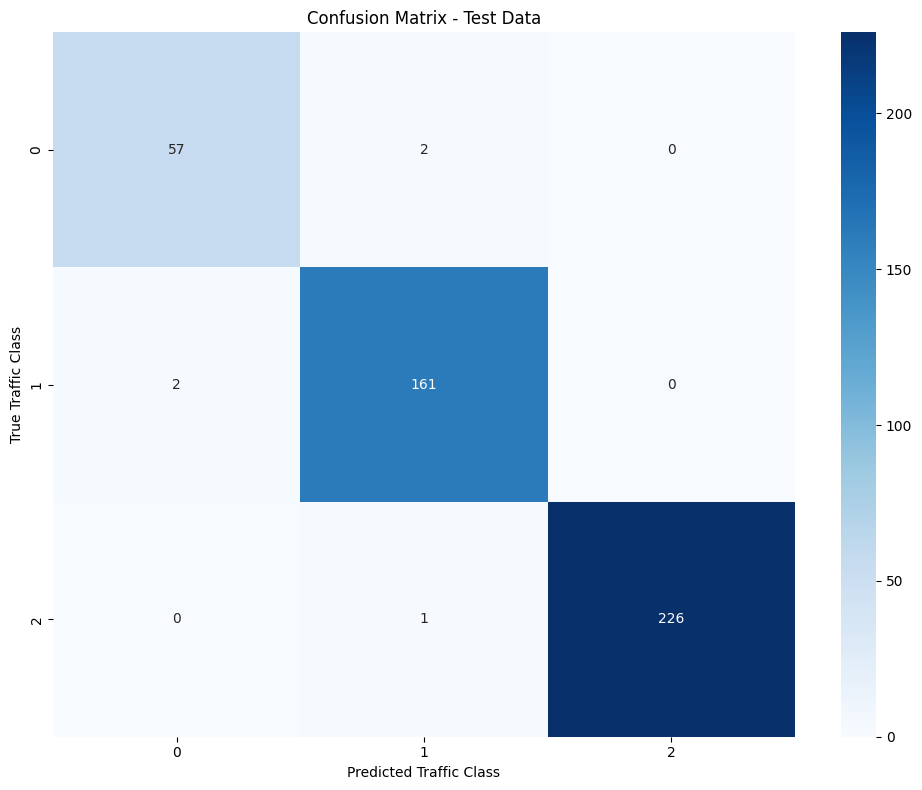


=== ERROR ANALYSIS ===
Number of misclassified instances: 5

Misclassifications by Month:
Month 1: 1 errors
Month 2: 1 errors
Month 4: 1 errors
Month 11: 1 errors
Month 12: 1 errors

Misclassifications by Country:
North America: 3 errors
Japan: 1 errors
United Kingdom: 1 errors

Class Transition Analysis (True -> Predicted):
Class 0 -> Class 1: 2 instances
Class 1 -> Class 0: 2 instances
Class 2 -> Class 1: 1 instances

=== CONCLUSION ===
The model achieved 98.89% accuracy on the test dataset.
This validates the model's ability to generalize to new, unseen data.
The high test accuracy suggests the model is reliable for production use.
The model can confidently be used to predict traffic classes for Singapore air travel.


In [11]:
"""
Singapore Air Traffic Class Prediction - Test Dataset Evaluation (with One-Hot Encoding)

This code evaluates a previously trained model on a separate test dataset to validate its performance.
Testing on a separate dataset is crucial to ensure the model generalizes well to new, unseen data
and isn't just memorizing the training data (overfitting).

The code handles:
1. Loading the test dataset
2. Applying the same feature engineering as during training (now using one-hot encoding)
3. Making predictions and evaluating performance
4. Analyzing errors to understand model limitations

Author: Myat Ko
"""

import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# =============================================================================
# LOAD TEST DATASET
# =============================================================================
# This section loads the separate test dataset that the model hasn't seen during training,
# which provides an unbiased evaluation of model performance.

print("=== LOADING TEST DATASET ===")

# Try multiple file paths to make the code more robust
try:
    test_df = pd.read_csv("test_data_with_traffic_class.csv")
except:
    # Alternative path if the first one doesn't work
    try:
        test_df = pd.read_csv("C:/Users/Myat Ko/Documents/GitHub/traveltrends/Classification/test_data_with_traffic_class.csv")
    except:
        # Exit with error message if the file can't be found
        print("Please check the test file path and try again.")
        exit(1)  # Stop execution if we can't find the test data

# Print basic information about the test dataset
print(f"Test dataset shape: {test_df.shape}")  # Number of rows and columns
print(f"Number of traffic classes in test data: {test_df['Traffic_Class'].nunique()}")  # How many classes
print(f"Traffic classes in test data: {sorted(test_df['Traffic_Class'].unique())}")  # The actual class values

# Check for missing values in the test dataset
# Handling missing values is important for accurate predictions
missing_values = test_df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in test dataset:")
    print(missing_values[missing_values > 0])  # Show only columns with missing values

# =============================================================================
# LOAD SAVED MODEL
# =============================================================================
# This section loads the previously trained and saved model from disk,
# including all preprocessing components and feature requirements.

print("\n=== LOADING SAVED MODEL ===")

# Define the path where the model was saved
# Updated to use the onehot model filename
model_path = os.path.join('models', 'traffic_class_predictor_onehot.pkl')

# Attempt to load the model and handle any errors
try:
    with open(model_path, 'rb') as f:
        # pickle.load deserializes the saved model object
        model_data = pickle.load(f)
    
    print("Model loaded successfully")
    
    # Extract the model, required features, and encoder from the saved data
    model = model_data['model']  # The trained model pipeline
    required_features = model_data['features']  # List of features the model needs
    encoder = model_data.get('encoder', None)  # Get the OneHotEncoder if available
    
    print(f"Model requires {len(required_features)} features")
except:
    # Exit if the model can't be loaded
    print(f"Error: Could not load model from {model_path}")
    exit(1)

# =============================================================================
# DATA PREPROCESSING
# =============================================================================
# This section prepares the test data with the same transformations that were applied
# during training. Consistency in preprocessing is essential for accurate predictions.

print("\n=== PREPROCESSING TEST DATA ===")

# Identify categorical columns (object type) for one-hot encoding
categorical_columns = [col for col in test_df.columns if test_df[col].dtype == 'object' and col != 'Traffic_Class']
if categorical_columns:
    print(f"Categorical columns detected: {categorical_columns}")

# Handle categorical features with one-hot encoding
# This needs to match the training preprocessing exactly
if categorical_columns and encoder is not None:
    print("\nApplying one-hot encoding to categorical columns...")
    
    # First, fill missing values in categorical columns
    for col in categorical_columns:
        test_df[col] = test_df[col].fillna('Unknown')
    
    # Apply one-hot encoding using the saved encoder
    encoded_cats = encoder.transform(test_df[categorical_columns])
    
    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    
    # Create a DataFrame with the encoded values
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=test_df.index)
    
    # Concatenate with the original DataFrame
    test_df = pd.concat([test_df, encoded_df], axis=1)
    
    print(f"- Created {len(encoded_feature_names)} one-hot encoded features")
    
    # Keep track of original columns to exclude from model features
    categorical_columns_to_drop = categorical_columns.copy()
else:
    categorical_columns_to_drop = []
    if categorical_columns:
        print("WARNING: Encoder not found in model data. One-hot encoding could not be applied.")

# Create required features that might be missing in the test data
# Each block below creates a specific feature type if needed

# 1. Create Years_Since_2000 feature if needed
if 'Years_Since_2000' in required_features and 'Years_Since_2000' not in test_df.columns:
    if 'Year' in test_df.columns:
        test_df['Years_Since_2000'] = test_df['Year'] - 2000
        print("- Created Years_Since_2000 feature")

# 2. Create seasonal indicators to capture time-based patterns
seasonal_features = ['Winter', 'Spring', 'Summer', 'Fall']
if any(feat in required_features for feat in seasonal_features) and not any(feat in test_df.columns for feat in seasonal_features):
    if 'Month' in test_df.columns:
        # Create binary indicators for each season (Northern hemisphere)
        test_df['Winter'] = test_df['Month'].isin([12, 1, 2]).astype(int)
        test_df['Spring'] = test_df['Month'].isin([3, 4, 5]).astype(int)
        test_df['Summer'] = test_df['Month'].isin([6, 7, 8]).astype(int)
        test_df['Fall'] = test_df['Month'].isin([9, 10, 11]).astype(int)
        print("- Created seasonal indicators")

# 3. Create traffic ratio features to capture proportional patterns
if 'Arrivals_Ratio' in required_features and 'Arrivals_Ratio' not in test_df.columns:
    if all(col in test_df.columns for col in ['Arrivals', 'Total_Traffic']):
        test_df['Arrivals_Ratio'] = test_df['Arrivals'] / (test_df['Total_Traffic'] + 1)  # Add 1 to avoid division by zero
        print("- Created Arrivals_Ratio feature")

if 'Departures_Ratio' in required_features and 'Departures_Ratio' not in test_df.columns:
    if all(col in test_df.columns for col in ['Departures', 'Total_Traffic']):
        test_df['Departures_Ratio'] = test_df['Departures'] / (test_df['Total_Traffic'] + 1)
        print("- Created Departures_Ratio feature")

# 4. Create holiday-related features
if 'Holiday_Present' in required_features and 'Holiday_Present' not in test_df.columns:
    if 'Total Holidays' in test_df.columns:
        test_df['Holiday_Present'] = (test_df['Total Holidays'] > 0).astype(int)  # Binary indicator for holidays
        print("- Created Holiday_Present feature")

if 'Holiday_Traffic_Ratio' in required_features and 'Holiday_Traffic_Ratio' not in test_df.columns:
    if all(col in test_df.columns for col in ['Total Holidays', 'Total_Traffic']):
        test_df['Holiday_Traffic_Ratio'] = test_df['Total Holidays'] / (test_df['Total_Traffic'] + 1)
        print("- Created Holiday_Traffic_Ratio feature")

# 5. Create logarithmic transformations to handle skewed distributions
for col in ['Arrivals', 'Departures', 'Total_Traffic']:
    log_col = f'Log_{col}'
    if log_col in required_features and log_col not in test_df.columns:
        if col in test_df.columns:
            test_df[log_col] = np.log1p(test_df[col])  # log1p adds 1 before taking log, handling zeros
            print(f"- Created {log_col} feature")

# 6. Create month-specific interaction features
# These capture how inflation affects different months differently
if 'Month' in test_df.columns and 'Inflation' in test_df.columns:
    for month in range(1, 13):
        col_name = f'Month{month}_Inflation'
        if col_name in required_features and col_name not in test_df.columns:
            test_df[col_name] = ((test_df['Month'] == month) * test_df['Inflation']).astype(float)
            print(f"- Created {col_name} feature")

# Create month-specific holiday features
# These capture how holidays affect different months differently
if 'Month' in test_df.columns and 'Total Holidays' in test_df.columns:
    for month in range(1, 13):
        col_name = f'Month{month}_Holidays'
        if col_name in required_features and col_name not in test_df.columns:
            test_df[col_name] = ((test_df['Month'] == month) * test_df['Total Holidays']).astype(float)
            print(f"- Created {col_name} feature")

# If there are any required features that start with original column names 
# plus "_" from one-hot encoding, we need to make sure they exist
for feature in required_features:
    if feature not in test_df.columns and not any(feature.startswith(f"{col}_") for col in categorical_columns):
        print(f"WARNING: Cannot create required feature: {feature}")

# Verify all required features are present
missing_features = [feat for feat in required_features if feat not in test_df.columns]
if missing_features:
    print("\nWARNING: The following required features are missing from test data:")
    for feat in missing_features:
        print(f"- {feat}")
    print("Prediction accuracy may be affected.")

# Extract features (X) and target (y) from the test data
# Make sure to exclude the original categorical columns that were one-hot encoded
X_test = test_df[required_features].copy()
y_test = test_df['Traffic_Class'].copy()

# Handle any remaining missing values in feature columns
for col in X_test.columns:
    if X_test[col].isnull().any():
        if X_test[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            # Fill numeric columns with median (robust to outliers)
            X_test[col] = X_test[col].fillna(X_test[col].median())
        else:
            # Fill categorical columns with most frequent value
            X_test[col] = X_test[col].fillna(X_test[col].mode().iloc[0])
        print(f"- Filled missing values in {col}")

# =============================================================================
# MODEL EVALUATION ON TEST DATA
# =============================================================================
# This section applies the trained model to make predictions on the test data,
# then evaluates how well those predictions match the actual values.

print("\n=== EVALUATING MODEL ON TEST DATA ===")

# Make predictions using the loaded model
y_pred = model.predict(X_test)

# Calculate overall accuracy (percentage of correct predictions)
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy on Test Data: {accuracy:.4f}")

# Generate detailed classification metrics
# This includes precision, recall, and F1-score for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for each class separately
# This helps identify if some classes are predicted better than others
class_accuracy = {}
for class_id in np.unique(y_test):
    class_mask = (y_test == class_id)  # Select only instances of this class
    class_correct = (y_pred[class_mask] == class_id).sum()  # Count correct predictions
    class_total = class_mask.sum()  # Total instances of this class
    class_accuracy[class_id] = class_correct / class_total  # Accuracy for this class

print("\nAccuracy by Traffic Class:")
for class_id, acc in sorted(class_accuracy.items()):
    print(f"Class {class_id}: {acc:.4f}")

# Create confusion matrix to visualize prediction patterns
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Traffic Class')
plt.xlabel('Predicted Traffic Class')
plt.tight_layout()
plt.show()

# =============================================================================
# ERROR ANALYSIS
# =============================================================================
# This section examines the misclassified instances to identify patterns or
# weaknesses in the model, which could guide future improvements.

print("\n=== ERROR ANALYSIS ===")

# Create a DataFrame that includes predictions and correctness
results_df = pd.DataFrame({
    'True_Class': y_test,  # Actual class
    'Predicted_Class': y_pred,  # Predicted class
    'Correct': y_test == y_pred  # Boolean indicating correct prediction
})

# Merge with original test data to analyze errors in context
analysis_df = pd.concat([test_df.reset_index(drop=True), results_df], axis=1)

# Analyze misclassifications - if any exist
if (y_test != y_pred).any():
    # Filter to only misclassified instances
    misclassified = analysis_df[~analysis_df['Correct']]
    print(f"Number of misclassified instances: {len(misclassified)}")
    
    # Analyze errors by month to see if certain times are problematic
    if 'Month' in misclassified.columns:
        print("\nMisclassifications by Month:")
        month_errors = misclassified.groupby('Month').size().sort_values(ascending=False)
        for month, count in month_errors.items():
            print(f"Month {month}: {count} errors")
    
    # Analyze errors by country to see if certain regions are problematic
    if 'Country' in misclassified.columns:
        print("\nMisclassifications by Country:")
        country_errors = misclassified.groupby('Country').size().sort_values(ascending=False)
        for country, count in country_errors.head(5).items():
            print(f"{country}: {count} errors")
    
    # Analyze which class transitions are most common in errors
    # This shows if the model confuses specific pairs of classes
    print("\nClass Transition Analysis (True -> Predicted):")
    transition_counts = misclassified.groupby(['True_Class', 'Predicted_Class']).size()
    for (true_class, pred_class), count in transition_counts.items():
        print(f"Class {true_class} -> Class {pred_class}: {count} instances")
else:
    # If there are no errors, celebrate!
    print("Perfect classification! No errors to analyze.")

# =============================================================================
# CONCLUSION
# =============================================================================
# This section summarizes the evaluation results and provides guidance on
# whether the model is ready for production use.

print("\n=== CONCLUSION ===")
print(f"The model achieved {accuracy*100:.2f}% accuracy on the test dataset.")
print("This validates the model's ability to generalize to new, unseen data.")

# Provide guidance based on the achieved accuracy
if accuracy >= 0.9:
    print("The high test accuracy suggests the model is reliable for production use.")
    print("The model can confidently be used to predict traffic classes for Singapore air travel.")
else:
    print("Further model tuning may be needed to improve performance on test data.")
    print("Consider additional feature engineering or trying different model architectures.")